# Vertical regridding and remapping of CMIP6 ocean data in the cloud
## C Spencer Jones, Julius Busecke, Takaya Uchida and Ryan Abernathey

### 1. Introduction

Many ocean and climate models output ocean variables (like velocity, temperature, oxygen concentration etc.) in depth space. Property transport in the ocean generally follows isopycnals, but isopycnals often move up and down in depth space. A small difference in the vertical location of isopycnals between experiments can cause a large apparent difference in ocean properties when the experiments are compared in depth space. As a result, it is often useful to compare ocean variables in density space. 

This work compares two algorithms for plotting ocean properties in density coordinates, one written in FORTRAN with a python wrapper ([xlayers](https://github.com/cspencerjones/xlayers)), and one written in xarray ([xarrayutils](https://github.com/jbusecke/xarrayutils)). Both algorithms conserve total salt content in the vertical, and both algorithms are easily parallelizable to enable plotting large datasets in density coordinates. As shown here, xlayers is a faster algorithm, but on some machines it requires more setup due to its reliance on a FORTRAN compiler.

Here, we apply these algorithms to plot salinity in density space in one of the Coupled Model Intercomparison Project Phase 6 (CMIP-6) models. We compare the salinity as a function of density in  two future greenhouse-gas scenarios. In general, areas with net precipitation today are getting fresher and areas with net evaporation today are getting saltier ([Durack and Wijffels, 2010](https://doi.org/10.1175/2010JCLI3377.1)). In climate models with a 1% per year CO$_2$ increase, areas with net precipitation today experience increasing precipitation, and areas with net evaporation today experience a further reduction in precipitation in higher greenhouse-gas scenarios ([Vallis et al. 2015](https://doi.org/10.1002/qj.2456)). Here we compare two different greenhouse gas scenarios in the Shared Socioeconomic Pathways experiments. By plotting salinity in density space, we visualize how changes in salinity at the surface propagate along isopycnals to influence salinity concentrations in the ocean interior. 

### 2. Loading CMIP-6 data
We choose to load temperature and salinity data from the [ACCESS-ESM1-5 model](https://doi.org/10.22499/2.6301.004), but this calculation can be performed on almost any CMIP-6 model currently available through [Google's public datasets program](https://cloud.google.com/blog/products/data-analytics/new-climate-model-data-now-google-public-datasets). 

In [2]:
#Load the packages needed
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
import zarr
import gcsfs
import matplotlib.pyplot as plt
import time
import warnings

# suppress warnings to improve readability
warnings.filterwarnings('ignore')

In [3]:
# Access the catalog of available CMIP-6 data
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
# Connect to google cloud storage (this only needs to be created once)
gcs = gcsfs.GCSFileSystem(token='anon')

# Write a query to find temperature (thetao) and salinity (so) in the ACCESS model
df_sub = df.query("source_id == 'ACCESS-ESM1-5' and member_id=='r1i1p1f1' and table_id=='Omon' \
                            and (experiment_id=='ssp126' or experiment_id=='ssp585')   \
                             and (variable_id=='thetao' or variable_id=='so')")
google_cloud_stores = df_sub.zstore.values
google_cloud_stores

array(['gs://cmip6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp126/r1i1p1f1/Omon/so/gn/',
       'gs://cmip6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp126/r1i1p1f1/Omon/thetao/gn/',
       'gs://cmip6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp585/r1i1p1f1/Omon/so/gn/',
       'gs://cmip6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp585/r1i1p1f1/Omon/thetao/gn/'],
      dtype=object)

We choose to compare properties for two future greenhouse gas scenarios, sometimes called [Shared Soceioeconomic Pathways](https://doi.org/10.1016/j.gloenvcha.2016.05.009). The first is a lower-emissions scenario, SSP1-2.6, and the second is a higher-emissions scenario, SSP5-8.5. The following code accesses the specific zarr stores that contain temperature and salinity data for these two pathways and sets up pointers to this data. 

In [4]:
# read the metadata from the cloud
datasets = [xr.open_zarr(gcs.get_mapper(zstore), consolidated=True)
            for zstore in google_cloud_stores]

# fix vertices coordinate
dsets_fixed = [ds.set_coords(['vertices_latitude', 'vertices_longitude'])
                  for ds in datasets]

# separate data so we can merge it more sensibly
ds_so_ssp126, ds_thetao_ssp126, ds_so_ssp585, ds_thetao_ssp585 = datasets

# merge temperature and salinity
ds_ssp126 = xr.merge([dsets_fixed[0], dsets_fixed[1]], compat='identical')
ds_ssp126.coords['experiment_id'] = 'experiment_id', ['ssp126']
ds_ssp585 = xr.merge([dsets_fixed[2], dsets_fixed[3]], compat='identical')
ds_ssp585.coords['experiment_id'] = 'experiment_id', ['ssp585']
 
# merge SSP1-2.6 with SSP5-8.5
ds = xr.concat([ds_ssp126, ds_ssp585], dim='experiment_id', compat='identical')
ds

<xarray.Dataset>
Dimensions:             (bnds: 2, experiment_id: 2, i: 360, j: 300, lev: 50, time: 1032, vertices: 4)
Coordinates:
    vertices_longitude  (j, i, vertices) float64 80.0 81.0 81.0 ... 80.0 80.0
    time_bnds           (time, bnds) datetime64[ns] 2015-01-01 ... 2101-01-01
    lev_bnds            (lev, bnds) float64 0.0 10.0 10.0 ... 5.665e+03 6e+03
    longitude           (j, i) float64 80.5 81.5 82.5 83.5 ... 79.96 79.97 79.99
    vertices_latitude   (j, i, vertices) float64 -78.0 -78.0 ... 65.0 65.42
    latitude            (j, i) float64 -77.88 -77.88 -77.88 ... 65.63 65.21
  * j                   (j) int32 0 1 2 3 4 5 6 ... 293 294 295 296 297 298 299
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * time                (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T12:00:00
  * lev                 (lev) float64 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
  * experiment_id       (experiment_id) object 'ssp126' 'ssp585'
Dimensions without coordinates: bnds, vertices
Data variables:
    so                  (experiment_id, time, lev, j, i) float32 dask.array<chunksize=(1, 6, 50, 300, 360), meta=np.ndarray>
    thetao              (experiment_id, time, lev, j, i) float32 dask.array<chunksize=(1, 5, 50, 300, 360), meta=np.ndarray>

### 3. Preparing data for plotting in density coordinates

The data in these stores is given in depth space. In order to plot the salinity in potential density coordinates, we need the potential density field in depth space. In the cell below, the gibbs seawater toolbox is applied to find the surface-referenced potential density from the temperature and salinity. The [ACCESS](https://doi.org/10.22499/2.6301.004) model actually uses the [Jackett et al 2006](https://doi.org/10.1175/JTECH1946.1) equation of state, but the density calculated here is a good approximation of the density in the ACCESS model.

In [5]:
import gsw

# calculate potential density from temperature and salinity
ds['dens'] = xr.apply_ufunc(gsw.density.sigma0, ds.so, ds.thetao,
                            dask='parallelized', output_dtypes=[float]).rename('dens')
ds

<xarray.Dataset>
Dimensions:             (bnds: 2, experiment_id: 2, i: 360, j: 300, lev: 50, time: 1032, vertices: 4)
Coordinates:
    vertices_longitude  (j, i, vertices) float64 80.0 81.0 81.0 ... 80.0 80.0
    time_bnds           (time, bnds) datetime64[ns] 2015-01-01 ... 2101-01-01
    lev_bnds            (lev, bnds) float64 0.0 10.0 10.0 ... 5.665e+03 6e+03
    longitude           (j, i) float64 80.5 81.5 82.5 83.5 ... 79.96 79.97 79.99
    vertices_latitude   (j, i, vertices) float64 -78.0 -78.0 ... 65.0 65.42
    latitude            (j, i) float64 -77.88 -77.88 -77.88 ... 65.63 65.21
  * j                   (j) int32 0 1 2 3 4 5 6 ... 293 294 295 296 297 298 299
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * time                (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T12:00:00
  * lev                 (lev) float64 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
  * experiment_id       (experiment_id) object 'ssp126' 'ssp585'
Dimensions without coordinates: bnds, vertices
Data variables:
    so                  (experiment_id, time, lev, j, i) float32 dask.array<chunksize=(1, 6, 50, 300, 360), meta=np.ndarray>
    thetao              (experiment_id, time, lev, j, i) float32 dask.array<chunksize=(1, 5, 50, 300, 360), meta=np.ndarray>
    dens                (experiment_id, time, lev, j, i) float64 dask.array<chunksize=(1, 5, 50, 300, 360), meta=np.ndarray>

Here, we plot sea surface salinity in 2015 (white contours in the figure below). Surface salinity tends to be lower in areas of high net precipitation and higher in areas of low net precipitation. Hence, if wet areas get wetter and dry areas get drier, we expect to see salty areas get saltier and fresh areas get fresher. 

Overwrite existing file: bilinear_300x360_160x240.nc 
 You can set reuse_weights=True to save computing time.


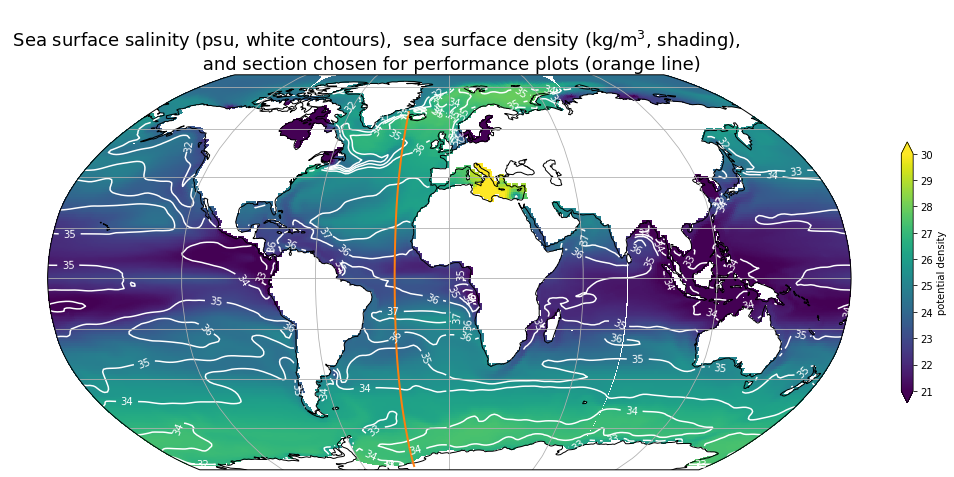

In [6]:
# find sea surface properties for SSP1-2.6 in 2015
ds_to_plot = ds.sel(experiment_id='ssp126').isel(lev=0).sel(time='2015').mean('time')

# Define sea-surface salinity and sea-surface density
ssd = ds_to_plot.dens
sss = ds_to_plot.so

# regrid sss for plotting
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-80, 80, 1.0)),
                     'lon': (['lon'], np.arange(0, 360, 1.5)),
                    })
regridder = xe.Regridder(sss.rename({'longitude':'lon','latitude':'lat'}), ds_out, 'bilinear');
sss_regrid = regridder(sss);


# plot sea-surface salinity, sea-surface density and chosen section for performance plots
fig = plt.figure(figsize=(18, 12))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
ssd.plot(x='longitude', y='latitude', ax=ax, transform=ccrs.PlateCarree(),
         vmin=21, vmax=30, cbar_kwargs={'shrink': 0.4, 'label':'potential density'})
CS = sss_regrid.plot.contour(levels=np.arange(32, 38, 1), transform=ccrs.PlateCarree(), colors='w')
CL = plt.clabel(CS, fmt='%d')

# note that the section location is i=255, j=0,250
lat_sec=ssd.sel(i=255, j=slice(0, 250)).latitude
lat_sec.plot(x='longitude', ax=ax, transform=ccrs.PlateCarree(), color='tab:orange', linewidth=2)
ax.set_title('\n Sea surface salinity (psu, white contours),  sea surface density (kg/m$^3$, shading),\
                           \n and section chosen for performance plots (orange line)', fontsize=18);

These simulations begin in 2015. We choose to compare salinities in 2100, the final year of the simulation. In the parts 4 and 5 of this notebook, we assess the performance of the two packages by plotting salinity in density space on a single section, which is shown by the orange line in the plot above. 

In order to do this, we load a small amount of data in the cell below. 

In [7]:
# Define the densities used in the new coordinate system
t_vals = np.arange(20.4, 28.1, 0.1)


# Define lev_bounds to be the cell edges in the vertical
ds = ds.assign_coords(lev_bounds = np.concatenate([ds.lev_bnds[:, 0].values, [6000]]), dims='lev_bounds');

# fill nans in the salinity with zeros
ds['so'] = ds['so'].fillna(0)

# load density and salinity on the chosen section in January 2100, 
# so that both methods are on a level playing field for benchmarking
ds_slice = ds.sel(i=255, j=slice(0, 250), time='2100-01').sel(experiment_id='ssp126').load()
ds_slice.load()

<xarray.Dataset>
Dimensions:             (bnds: 2, j: 251, lev: 50, lev_bounds: 51, time: 1, vertices: 4)
Coordinates:
    vertices_longitude  (j, vertices) float64 335.0 336.0 336.0 ... 335.9 334.9
    time_bnds           (time, bnds) datetime64[ns] 2100-01-01 2100-02-01
    lev_bnds            (lev, bnds) float64 0.0 10.0 10.0 ... 5.665e+03 6e+03
    longitude           (j) float64 335.5 335.5 335.5 ... 335.5 335.4 335.4
    vertices_latitude   (j, vertices) float64 -78.0 -78.0 -77.75 ... 67.67 67.66
    latitude            (j) float64 -77.88 -77.63 -77.38 ... 66.55 67.0 67.44
  * j                   (j) int32 0 1 2 3 4 5 6 ... 244 245 246 247 248 249 250
    i                   int32 255
  * time                (time) datetime64[ns] 2100-01-16T12:00:00
  * lev                 (lev) float64 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
    experiment_id       <U6 'ssp126'
  * lev_bounds          (lev_bounds) float64 0.0 10.0 20.0 ... 5.665e+03 6e+03
    dims                <U10 'lev_bounds'
Dimensions without coordinates: bnds, vertices
Data variables:
    so                  (time, lev, j) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    thetao              (time, lev, j) float32 nan nan nan nan ... nan nan nan
    dens                (time, lev, j) float64 nan nan nan nan ... nan nan nan

### 4. Evaluating the performance of xarrayutils
In this section, we use xarrayutils to transform salinity into density space.

In [8]:
# import xarrayutils
from xarrayutils.vertical_coordinates import conservative_remap
from xarrayutils.vertical_coordinates import linear_interpolation_regrid

xarrayutils transforms salinity into density space in two steps. First, there is a regridding step, in which the depths of the density surfaces are found. Then there is a remapping step, in which the salinity is remapped onto these new depth levels. Below, we perform both steps on the loaded section in order to assess the performance of the package. 

In [9]:
# here, we define  a function that applies the xarrayutils package to the data
def apply_xarrayutils(ds_slice, t_vals):
    # define the new density grid
    density_values = xr.DataArray(t_vals, coords=[('t', t_vals)]) 

    # Find the depth of these surfaces 
    z_dens_bounds = linear_interpolation_regrid(ds_slice.lev, ds_slice.dens, density_values, z_bounds=ds_slice.lev_bounds ,target_value_dim='t', z_bounds_dim='lev_bounds')

    # define the cell boundaries in the original salinity field
    bounds_original = ds_slice.lev_bounds

    # Remap salinity into density space
    ds_dens_cons = conservative_remap(ds_slice.so.squeeze(), bounds_original, z_dens_bounds.squeeze(),
                                   z_dim='lev', z_bnd_dim='lev_bounds', z_bnd_dim_target='regridded', mask=True
                                    ) # the associated depth dimensions for each array

    # replace the new depth dimension values with the appropriate depth (here the middle of the density cell bounds)
    t_vals = z_dens_bounds.coords['regridded'].data
    t_vals = 0.5 * (t_vals[1:] + t_vals[0:-1])

    ds_dens_cons.coords['remapped'] = xr.DataArray(t_vals, coords=[('remapped', t_vals)])
    return ds_dens_cons, z_dens_bounds


# here we apply the function to the loaded data
# start the timer
start = time.time()

# apply xarrayutils to a single slice of salinity data
ds_dens_cons, z_dens_bounds=apply_xarrayutils(ds_slice, t_vals)

# stop the timer
end = time.time()

#print how long this took
print('It takes {:.2f} seconds to perform this transformation using xarrayutils'.format(end-start))

It takes 0.15 seconds to perform this transformation using xarrayutils


Next, we check that the depth-integrated salinity of the water column before the transformation is equal to the depth-integrated salinity of the column after the transformation. 

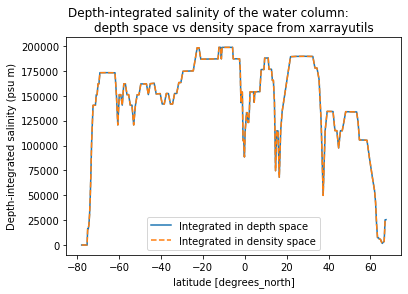

In [10]:
# find the height of the grid cells in density space
dz_remapped = z_dens_bounds.diff('regridded').rename({'regridded':'remapped'})
dz_remapped.coords['remapped'] = ds_dens_cons.coords['remapped'].values

# find the depth integrated salinity in depth space (blue line) for a single experiment for easy comparison
sal_depth = ((ds_slice.so*ds.lev_bnds.diff('bnds')).sum('lev'))

# find the depth integrated salinity in density space (orange dashed line)
sal_dens = (ds_dens_cons*dz_remapped).sum('remapped')

# plot the depth-integrated salinity before and after transformation
sal_depth.swap_dims({'j':'latitude'}).plot()
sal_dens.swap_dims({'j':'latitude'}).plot(linestyle='dashed')
plt.ylabel('Depth-integrated salinity (psu m)')
plt.legend(('Integrated in depth space', 'Integrated in density space'))
plt.title('Depth-integrated salinity of the water column:\
             \ndepth space vs density space from xarrayutils');

Note that the two lines in this figure are on top of each other: the total salt content of the water column before transformation equals the total salt content of the water column after transformation.

Next, we plot the difference in the salinity in January of 2100. 

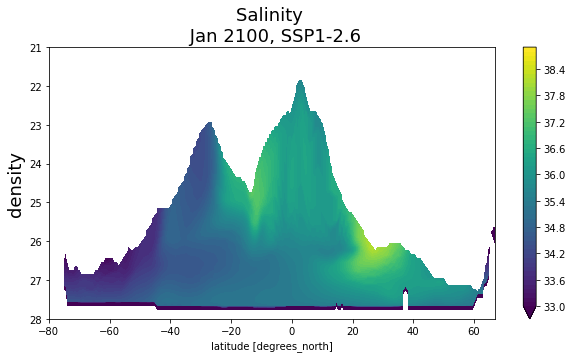

In [11]:
# find the salinity in density space
sal_dens = ds_dens_cons.where(dz_remapped>0)

# plot salinity in density space
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
(sal_dens.squeeze().swap_dims({'j':'latitude'})
                      ).plot.contourf(x='latitude', y='remapped', ax=ax, levels=np.arange(33, 39, 0.1))
ax.set_title('Salinity \n Jan 2100, SSP1-2.6', fontsize=18)
ax.set_ylabel('latitude', fontsize=18)
ax.set_ylabel('density', fontsize=18)
ax.set_ylim(28, 21)
ax.set_xlim(-80, 67);

### 5. Evaluating the performance of xlayers
xlayers uses a different algorithm from xarrayutils to transform data in one vertical coordinate system into another coordinate system. Here, we apply xlayers to the same dataset in order to compare its performance and results with those of xarrayutils.

In [11]:
# Load xlayers
from xlayers import finegrid, layers
from xlayers.core import layers_apply

In [12]:
# xlayers takes the locations of cell edges in a particular format, as calculated here
def finegrid_metrics(levs, lev_bnds):
    drF = np.diff(lev_bnds, axis=1)
    drC = np.concatenate((np.array([levs[0]]), np.diff(levs, axis=0), np.array([lev_bnds[-1, -1]-levs[-1]])))
    return(drF, drC)

# fine_drf is the depth of cells in the vertical and fine_drc is the height difference
# between cell centers in the vertical
fine_drf, fine_drc = finegrid_metrics(ds_slice.lev.values, ds.lev_bnds.values)

xlayers does both regridding and remapping all in one step, but requires an initial calculation of various indices needed for binning. The output of `layers_apply` is thickness weighted i.e. 
\begin{equation}
O(\rho_1 \mbox{ to } \rho_2)=\int_{z(\rho_1)}^{z(\rho_2)} I(z) dz \, , 
\end{equation}
where $I(z)$ is the input and $O(\rho_1 \mbox{ to } \rho_2)$ is the output in the layer between $\rho_1$ and $\rho_2$.

Now, we time the calculation of the thickness-weighted salinity, `sal_lay` and the thickness of each layer, `th_lay`, in density space using xlayers.

In [13]:
# start the timer
start = time.time()

# Calculated the thickness-weighted salinity using xlayers
sal_lay = layers_apply(ds_slice.so.squeeze(), ds_slice.dens.squeeze(), t_vals, 
                           fine_drf, fine_drc, 10, 'lev', 'Tlev')


# Calculated the thickness of each new layer (needed to back out the real salinity)
# using xlayers
th_lay = layers_apply(xr.ones_like(ds_slice.so.squeeze()), ds_slice.dens.squeeze(), t_vals, 
                           fine_drf, fine_drc, 10, 'lev', 'Tlev')

# stop the timer
end = time.time()

#print how long this took
print('It takes {:.5f} seconds to perform this transformation using xlayers'.format(end-start))

It takes 0.06132 seconds to perform this transformation using xlayers


xlayers generally takes about 0.05 seconds to transform this salinity field into density coordinates. In other words xlayers is at least 2x faster than xarrayutils.

Again, we confirm that this algorithm conserves ocean properties by checking that the depth-integrated salinity before transformation is equal to the depth-integrated salinity after the transformation. 

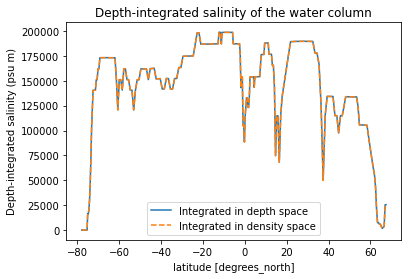

In [14]:
# find the depth integrated salinity in depth space (blue line)
sal_depth = ((ds_slice.so*ds.lev_bnds.diff('bnds')).sum('lev'))

# find the depth integrated salinity in density space (orange dashed line)
sal_dens = sal_lay.sum('Tlev')


# plot as a function of latitude
sal_depth.swap_dims({'j':'latitude'}).plot()
sal_dens.swap_dims({'j':'latitude'}).plot(linestyle='--')
plt.title('Salt content of the water column')
plt.ylabel('Depth-integrated salinity (psu m)')
plt.legend(('Integrated in depth space','Integrated in density space'))
plt.title('Depth-integrated salinity of the water column');

The orange dashed line is on top of the blue line, indicating that the total salt content of the water column before the transformation into density space equals the total salt content of the water column after transformation into density space.

We plot the difference in salinity in January 2100. 

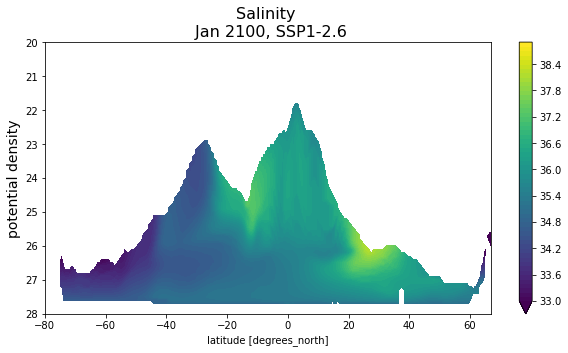

In [15]:
# Find the salinity in density space
sal_dens = sal_lay/th_lay

# Plot the salinity in density space
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sal_dens.plot.contourf(x='latitude',y='Tlev', levels=np.arange(33, 39, 0.1), ax=ax)
ax.set_title('Salinity \n Jan 2100, SSP1-2.6', fontsize=16)
ax.set_ylabel('potential density', fontsize=14)
ax.set_ylabel('latitude', fontsize=14)
ax.set_ylim(28, 20)
ax.set_xlim(-80 ,67);

Note that xarrayutils and xlayers produce very similar results, but xlayers generally produces more sensible values for salinity at the deepest density levels. 

## 6. Using a cluster to examine  "wet gets wetter, dry gets drier" pattern in density coordinates

The two scenarios begin from identical initial conditions, with greenhouse gas emissions growing faster in SSP5-8.5 than in SSP1-2.6. Hence we expect that wet regions will be wetter dry regions will be drier to a greater extent in SSP5-8.5 than in SSP1-2.6.

We want to compare our salinity in density space to sea surface salinity at the beginning of the simulation, in order to find out whether salty regions are getting saltier and fresh regions are getting fresher. Below, we calculate surface salinity as a function of density in the year 2015.

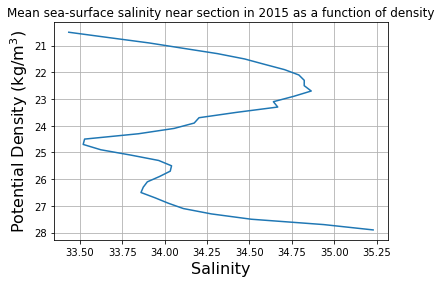

In [16]:
# This calculation is performed using the xhistogram package 
from xhistogram.xarray import histogram

# Define density bins
bins1 = np.hstack([np.arange(20.4, 28.1, 0.2)])
bins2 = np.arange(20, 40, 0.1)

# define salinity at the surface in 2015
sss15 = ds.so.sel(experiment_id='ssp126').isel(lev=0).sel(time='2015')

# define density at the surface in 2015
ssd15 = ds.dens.sel(experiment_id='ssp126').isel(lev=0).sel(time='2015').chunk({'time':6})

#histogram of density at surface in 2015, weighted by salinity
hist_sal = histogram(ssd15, bins=[bins1], weights=sss15)
        
#histogram of density at surface in 2015
hist_dens = histogram(ssd15, bins=[bins1])

#mean sea-surface salinity as a function of density
mean_sal = hist_sal/hist_dens
                   
# plot
mean_sal.plot(y='dens_bin')
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('Salinity', fontsize=16)
plt.ylabel('Potential Density (kg/m$^3$)', fontsize=16)
plt.title('Mean sea-surface salinity near section in 2015 as a function of density');

Surface salinities on isopycnals lighter than 24kg/m$^3$ and heavier than 27kg/m$^3$ are generally salty and surface salinities on isopycnals between 24kg/m$^3$ and 27kg/m$^3$ are generally fresh. Based on this plot, we expect isopycnals with densities less than 24kg/m$^3$ to get saltier and isopycnals with densities between 24kg/m$^3$ and 27kg/m$^3$ to get fresher.

We would like to compare the salinities for the globe the whole year. However, in order to find the mean salinity in density space over the whole year, we must take the thickness-weighted average. Described in [Young 2012](https://doi.org/10.1175/JPO-D-11-0102.1), thickness weighting is important for preventing relatively thin isopycnal layers from disproportionately affecting the mean salinity. In discretized form it follows
\begin{equation}
\tilde{S}(\rho_1 \mbox{ to } \rho_2)=\frac{\int_{t_1}^{t_2}\int_{z(\rho_1)}^{z(\rho_2)} S(z) dz \, dt}{\int_{t_1}^{t_2}\int_{z(\rho_1)}^{z(\rho_2)} dz\, dt} \, , 
\end{equation}
where $\rho_1$ and $\rho_2$ are the bounds of the isopycnal layer, and $\tilde{S}$ is the thickness weighted average salinity in the density layer between $\rho_1$ and $\rho_2$. The thickness-weighted time and zonal average salinity for the year 2100 is plotted below. 

In [17]:
# Set up a cluster using dask
from dask_gateway import Gateway
from dask.distributed import Client

gateway = Gateway()
cluster = gateway.new_cluster()

cluster.scale(5)
cluster

In [18]:
#Make a client so you can see the progress of tasks (click the link that appears below)
client = Client(cluster)
client

Client Scheduler: gateway://traefik-prod-dask-gateway.prod:80/prod.783b554396454767af7d5d3e8e0f0e16 Dashboard: https://hub.binder.pangeo.io/services/dask-gateway/clusters/prod.783b554396454767af7d5d3e8e0f0e16/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


First, we plot the mean for the year 2100 using xarrayutils.

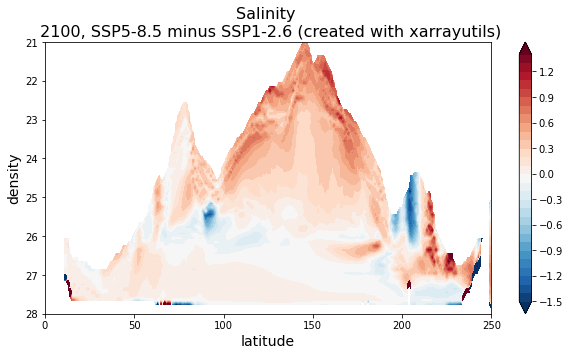

In [19]:
# define section for the year 2100
ds_glob = ds.sel(i=255, time='2100', j=slice(0, 250))

# calculate the salinity in density space
ds_dens_cons, z_dens_bounds = apply_xarrayutils(ds_glob, t_vals)

# find thickness weighting
dz_remapped = z_dens_bounds.diff('regridded').rename({'regridded':'remapped'})
dz_remapped.coords['remapped'] = ds_dens_cons.coords['remapped'].values

# Find thickness weighted salinity, averaged in time
tw_xau2100 = (ds_dens_cons*dz_remapped).sum('time')/dz_remapped.sum('time')

# Find difference between experiments SSP5-8.5 and SSP1-2.6
difference = tw_xau2100.sel(experiment_id='ssp585')-tw_xau2100.sel(experiment_id='ssp126')

# plot difference
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

difference.plot.contourf(x='j', y='remapped', ax=ax, levels=np.arange(-1.5, 1.5, 0.1), cmap='RdBu_r')
ax.set_title('Salinity \n 2100, SSP5-8.5 minus SSP1-2.6 (created with xarrayutils)', fontsize=16)
ax.set_ylabel('density', fontsize=14)
ax.set_xlabel('latitude', fontsize=14)
ax.set_ylim(28, 21);

We can plot the global and year average with xlayers though:

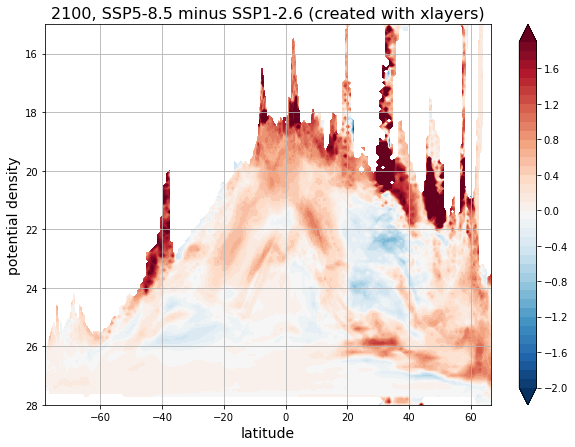

In [20]:
# define gloabel dataset for the year 2100
ds_glob = ds.sel(j=slice(0, 250), time='2100')

# prepare inputs for xarrayutils
salinity_in = ds_glob.so.chunk({'time': 1})
density_in = ds_glob.dens.chunk({'time': 1})

# Redefine density coords (the global ocean has some water that is lighter than the lightest water in our section)
denslayers = np.hstack([np.arange(15, 28.1, 0.1)])

# find thicknes-weighted salinity
sal_lay = layers_apply(salinity_in, density_in, denslayers, 
                           fine_drf, fine_drc, 10, 'lev', 'Tlev')


# Calculated the thickness of each new layer (needed to back out the real salinity)
th_lay = layers_apply(xr.ones_like(salinity_in), density_in, denslayers, 
                           fine_drf, fine_drc, 10, 'lev', 'Tlev')


# Find thickness-weighted average salinity, over the whole globe for the year 2100
tw_xlay = (sal_lay.sum('time').sum('i')/th_lay.sum('time').sum('i'))

# Find the difference between experiments SSP5-8.5 and SSP1-2.6
difference = tw_xlay.sel(experiment_id='ssp585')-tw_xlay.sel(experiment_id='ssp126')

#define latitude for plotting (at the latitudes chosen, latitude is constant in i)
difference['mlatitude']=salinity_in['latitude'].mean('i')

# plot difference
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
difference.plot.contourf(x='mlatitude',y='Tlev', levels=np.arange(-2, 2, 0.1), ax=ax)
ax.set_title('2100, SSP5-8.5 minus SSP1-2.6 (created with xlayers)', fontsize=16)
ax.set_ylabel('potential density', fontsize=14)
ax.set_xlabel('latitude', fontsize=14)
ax.grid()
ax.set_ylim(28, 15);

The above plot is the zonal average for the whole globe.  In general the salinity appears to be increasing for densities greater than 24kg/m$^3$ and decreasing for densities between 24kg/m$^3$ and 27kg/m$^3$, as predicted by "wet gets wetter, dry gets drier". However, between 20N and 40N, there is a lot of freshening at lighter densities: further investigation of this is needed. 

### 7. Conclusions
We transform salinity from the ACCESS model into density coordinates using two different property-conserving algorithms, xarrayutils and xlayers. Xlayers is about 2x faster than xarrayutils, but xarrayutils is easier to set up on some systems because it does not require a FORTRAN compiler. The salinity in isopycnal space is similar between the two algorithms. We plan to continue to refine these algorithms and perhaps combine them into a single package in future. 

 In general the subtropics has net evaporation, i.e. it is a dry region, and the subpolar region has net precipitation, i.e. it is a wetter region. As greenhouse gas levels increase, wet regions are generally thought to get wetter and dry regions are thought to get drier (see e.g. [Vallis et al. 2015](https://doi.org/10.1002/qj.2456)). Using output from two scenarios in the ACCESS model, we show here that the salinity in density space is consistent with this "wet gets wetter and dry gets drier" hypothesis: for scenarios with more greenhouse gases in the atmosphere, higher salinities are seen in the tropics and lower salinities are seen in the subtropics. 

In [21]:
cluster.close()

### 8. Acknowledgements

Parts of this notebook were originally developed as part of the CMIP6 Hackathon, which was supported by funding from [US-CLIVAR](https://usclivar.org/) and [OCB](https://www.us-ocb.org/). We acknowledge support from Pangeo (NSF award 1740648).

### 9. References
Durack, P. J. and Wijffels, S. E., 2010: Fifty-Year Trends in Global Ocean Salinities and Their Relationship to Broad-Scale Warming. *J. Clim.*, **23**, 4342--4362, doi: 10.1175/2010JCLI3377.1

Vallis, G. K., Zurita-Gotor, P., Cairns, C., and Kidston, J., 2014: Response of the large‐scale structure of the atmosphere to global warming. *Q. J. R. Meteorol. Soc*, **141**, 1479-1501, doi:10.1002/qj.2456

Bi, D., Dix, M., Marsland, S. J., O’Farrell, S., Rashid, H., Uotila, P., ... and Yan, H. 2013., The ACCESS coupled model: description, control climate and evaluation. *Aust. Meteorol. Oceanogr. J*, **63**(1), 41-64.

Riahi, K., Van Vuuren, D. P., Kriegler, E., Edmonds, J., O’neill, B. C., Fujimori, S., ... and Lutz, W., 2017. The shared socioeconomic pathways and their energy, land use, and greenhouse gas emissions implications: an overview. *Global Environmental Change*, **42**, 153-168.